# Lab:   Unsupervised learning - K-means Clustering

Objectives: Implement K-means clustering algorithm and apply it for image compression. 

In [157]:
#Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
import pandas as pd

### Part 1: Load and plot 2D Data
Start on a toy 2D dataset to gain an intuition of how K-means algorithm works.

<img src="images/f2.png" style="width:350px;height:250px;">
<caption><center> Fig. 1 : Training data</center></caption>

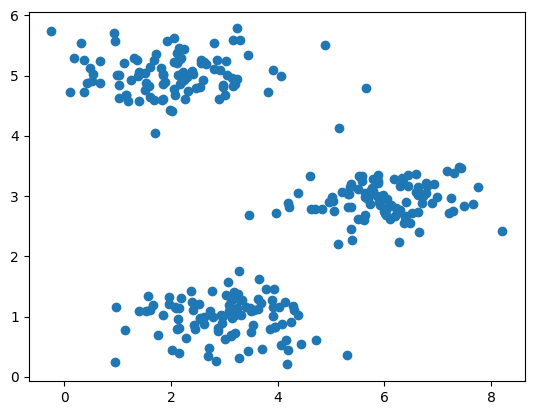

In [158]:
# load matlab file ex7data2.mat and extact X

mat = loadmat("ex7data2.mat")

X = mat["X"]

# Plot the data and get a figure similar to Fig.1.

plt.scatter(mat["X"][:, 0], mat["X"][:, 1])

### K-means algorithm

K-means is a method to automatically cluster similar data examples together. You have a training set ${x^{(1)} , ..., x^{(m)} }$, where $x^{(i)} ∈ R^n $, and want to group the data into a few cohesive clusters. K-means is an iterative procedure that starts by guessing the initial centroids, and then reﬁnes this guess by repeatedly assigning examples to their closest centroids and then re-computing the centroids based on the assignments. 

The algorithm repeatedly carries out two steps: 

(i) Assigning each training example x(i) to its closest centroid

(ii) Re-computing the mean of each centroid using the points assigned to it. 

K-means algorithm will always converge to some ﬁnal set of centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice K-means usually runs a few times with different random initializations. One way to choose the best clustering solution is to choose the one with the lowest cost function value (distortion). 

### Finding closest centroids
In the K-means cluster assignment phase, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of the centroids. Speciﬁcally, for every example $x^{(i)}$ we set

$c^{(i)} := j$ that minimizes $\|x^{(i)} - u_j\|^2$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $u_j$ is the position of the j’th centroid. Note that $c^{(i)}$ corresponds to idx[i] in the code below.

Function *findClosestCentroids* takes the data matrix X and the locations of all centroids and outputs a one-dimensional array idx that holds the index of the closest centroid to every training example. The index is an integer value in {1, ..., K}, where K is the number of centroids. This is implemented using a loop over every training example. 

Complete *findClosestCentroids* and run it to see the centroid assignments for the ﬁrst 3 examples.


In [159]:
def findClosestCentroids(X, centroids):
    """
    Returns vector idx with the index of the closest centroid for 
    every example in dataset X (each row is a single example).
    """
    K = centroids.shape[0]  # number of clusters
    m = X.shape[0]          # number of examples

    #Inicialize vector idx with zeros (dimension mx1)
    idx = np.zeros(m)
    
    temp = np.zeros((centroids.shape[0],1))
    
    #cicle for over all examples in the data set
    for i in range(m):
        #cilce for over all clusters 
        for j in range(K):
            #Compute the distance between each example and each centroid
            dist = X[i,:] - centroids[j,:]
            temp[j] = np.sum(dist**2)
        
        # assign the closest cetroid for example i  
        idx[i] = np.argmin(temp)+1
    
    return idx

In [160]:
# Test function findClosestCentroids

#Position of the initial_centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])

K = initial_centroids.shape[0] #number of clusters

# call function findClosestCentroids
idx = findClosestCentroids(X, initial_centroids)

# Closest centroids for the first 3 examples ? => ANSWER  [1 3 2]
print("Closest centroids for the first 3 examples:", idx[:3])


Closest centroids for the first 3 examples: [1. 3. 2.]


### Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm re-computes, for each centroid, the mean of the points that were assigned to it. Speciﬁcally, for every centroid k we set 

$u_k := \frac{1}{C_k} \Sigma_{i\in C_k}x^{(i)}$

where ${C_k}$ is the set of examples assigned to centroid k. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid k=2, then you should update $u_2=0.5(x^{(3)} + x^{(5)})$. 

Complete function *computeCentroids* and run it to output the new positions of the centroids after the ﬁrst step of K-means.


In [161]:
def computeCentroids(X, idx, K):
    """
    K- number of clusters; X -data matrix; 
    idx - index of the closest centroid to every training example. 
    
    Returns the new centroids by computing the means of the data points assigned to each centroid.
    """
    m = X.shape[0]          # number of examples
    n = X.shape[1]          # Number of features (coordinates)
    
    #Inicialize the centroids by matrix of zeros, 
    # choose well the matrix dimension
    centroids = np.zeros((K, n))
    count = np.zeros((K,1))
    
    for i in range(m):
        index = int((idx[i]-1))
        centroids[index,:]+=X[i,:]
        count[index]+=1
    
    return centroids/count

In [162]:
# call function computeCentroids to compute centroids
centroids = computeCentroids(X, idx, K)

print("Centroids computed after initial finding of closest centroids")
print(centroids)


Centroids computed after initial finding of closest centroids
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


### Random Initialization

A good strategy for initializing the centroids is to select random examples from the training set. 

Complete the function *kMeansInitCentroids*. 

In [163]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids to be used in K-Means on 
    dataset X
    """
    m = X.shape[0]          # number of examples
    n = X.shape[1]          # Number of features (coordinates)
    
    #Inicialize the centroids  by matrix of zeros
    centroids = np.zeros((K, n))
    
    for i in range(K):
        centroids[i] = X[np.random.randint(0,m+1),:] #choose K random examples from the data set
        
    return centroids

### Run and Visualize K-means 

Now you have the two functions (*findClosestCentroids* and *computeCentroids*) completed, the next step is to run K-means algorithm on the toy 2D dataset.  The two functions are called from inside *plotKmeans* function. 

In [164]:
def plotKmeans(X, centroids, K, num_iters):
    """
    plots the data points with colors assigned to each centroid
    """
    m = X.shape[0]          # number of examples
    n = X.shape[1]          # Number of features (coordinates)
    
    
    fig, ax = plt.subplots(nrows=num_iters,ncols=1,figsize=(6,36))
    
    for i in range(num_iters):    
        
        # assign each training example to the nearest centroid
        idx = findClosestCentroids(X, centroids)
                
        # Compute the centroids mean
        centroids = computeCentroids(X, idx, K)
        
        # Visualisation of data
        color = "rgb"
        for k in range(1,K+1):
            grp = (idx==k).reshape(m,1)
            ax[i].scatter(X[grp[:,0],0],X[grp[:,0],1],c=color[k-1],s=15)

        # visualize the new centroids
        ax[i].scatter(centroids[:,0],centroids[:,1],s=120,marker="x",c="black",linewidth=3)
        title = "Iteration Number " + str(i)
        ax[i].set_title(title) 

    
    plt.tight_layout()

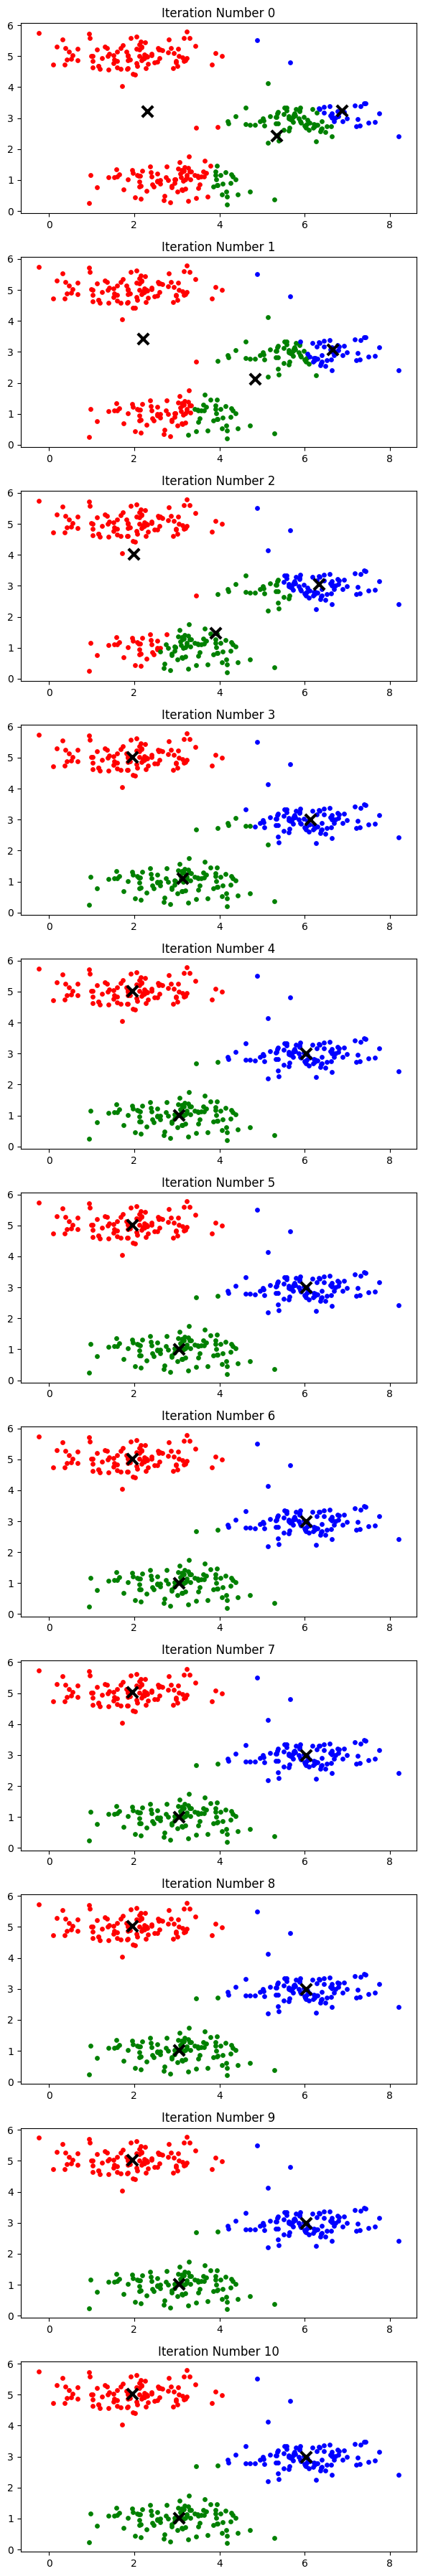

In [165]:
# Initialize the centroids to random examples from the training set
initial_centroids = kMeansInitCentroids(X, K)

# Run and Visualize K-means for 11 iterations
plotKmeans(X, centroids, K, 11)

### Part 2: Image Compression with K-means

Now, you will apply K-means to image compression. In a 24-bit color representation of an image, each pixel is represented by an 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values (RGB encoding). The image contains thousands of colors, and now, you will reduce the number of colors to 16.  By making this reduction, it is possible to represent the photo in a compressed form (only 4 bits are necessary to represent 16 colors).  

You will use K-means to select the 16 colors to represent the compressed image. Every pixel in the original image is treated as a data example and you use K-means to ﬁnd the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. The final cluster centroids
represent the 16 colors to replace the pixels in the original image.

The code ﬁrst loads the image, and then reshapes it to create a 2-D matrix X2 (mx3) of the pixels, where m= 16384 = 128×128, the number of pixels for each RGB color, and calls the K-means function on it. After ﬁnding the top K=16 colors to represent the image, each pixel is substituted by its closest centroid. This allows to represent the original image using the centroid assignments of each pixel. The original image required 24 bits (3*8) for each pixel, resulting in total size of 128 × 128 × 24 = 393216 bits. The new representation requires 16 colors (i.e. 4 bits per pixel). The ﬁnal number of bits used is therefore 128×128×4=65920 bits, which corresponds to compressing the original image by about a factor of 6.

In [166]:
# Load  the variable A (the image) saved in file bird_small.mat
 
A = loadmat("bird_small.mat")["A"]

#Check what is the shape of image A
print(A.shape)

#Normalize all pixels to become < 1 
A = A.astype(np.float64) / 255.0

#reshape A to one long vector of all pixels for each chanel (RGB)

# X2.shape = number_pixels x number_chanels (RGB)
X2 = A.reshape(-1, 3)
print(X2)
print("X2 shape:", X2.shape)


(128, 128, 3)
[[0.85882353 0.70588235 0.40392157]
 [0.90196078 0.7254902  0.45490196]
 [0.88627451 0.72941176 0.43137255]
 ...
 [0.25490196 0.16862745 0.15294118]
 [0.22745098 0.14509804 0.14901961]
 [0.20392157 0.15294118 0.13333333]]
X2 shape: (16384, 3)


In [167]:
def runKmeans(X, centroids,num_iters,K):
     
    for i in range(num_iters):
                
        # assign each training example to the nearest centroid
        idx = findClosestCentroids(X, centroids)
        
        # Compute the centroids mean
        centroids = computeCentroids(X, idx, K)
       
    return centroids, idx

In [168]:
# Run K-means algorithm on the image data
K2 = 64
num_iters = 10

initial_centroids2 =  kMeansInitCentroids(X2, K2)
print(initial_centroids2.shape)
centroids2, idx2 = runKmeans(X2, initial_centroids2, num_iters, K2)
print(centroids)

(64, 3)
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


You can now view the eﬀects of the compression by reconstructing the image based only on the centroid assignments.Fig. 1 shows the original and compressed images. Even though the resulting image retains most of the characteristics of the original, we also see compression artifacts.


<img src="images/f1.png" style="width:350px;height:200px;">
<caption><center> Fig.1: Original and reconstructed image (using K-means to compress the image)</center></caption>

Text(0.5, 1.0, 'Compressed image (with 64 colors)')

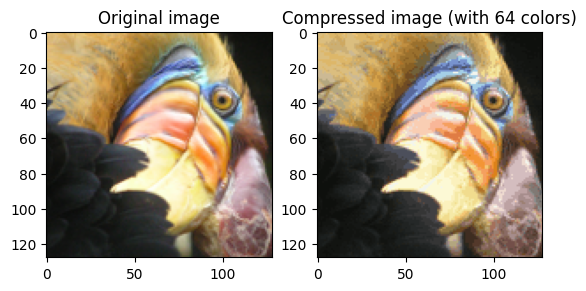

In [169]:
#X2_recovered = X2.copy()
X2_recovered = X2
for i in range(1,K2+1):
    X2_recovered[(idx2==i).ravel(),:] = centroids2[i-1]

# Display the images
import matplotlib.image as mpimg
fig, ax = plt.subplots(1,2)
ax[0].imshow(A)
ax[0].set_title("Original image") 

# Reshape the recovered image into proper dimensions
ax[1].imshow(X2_recovered.reshape(128,128,3))
ax[1].set_title("Compressed image (with " + str(K2) + " colors)") 

#### Best compresson ?

Choose the best number of clusters so that the difference between the original image and the compressed is not noticable. 


In [ ]:
#  64 Looks good(ish)